# JMAG111 - Demo on Modeling of Point Sources (Single click)

In this notebook, we will demonstrate – via the finite-difference modeling approach – the response of one and more point sources.

---

## Notes for First-Time Users

1. **Runtime:**  
   - Use Google Colab (recommended) or a local Jupyter Notebook with Python ≥3.10.  
   - If Colab: set *Runtime → Change runtime type → GPU (optional)* for speed.  

2. **Dependencies:**  
   - `numpy`, `matplotlib`, `scipy`, `imageio` are auto-installed by the script.  
   - The solver requires custom modules `seistools.py` and `fdtdac.py` (inside `src/`).

3. **Initial Setup:**  
   - Upload the provided ZIP file (`JMAG111_FD_and_ImagingDemonstration.zip`) *only on first run*.  
   - The code auto-extracts `src/` and remembers it in `/content/` for subsequent runs.  
   - If `src/` already exists, no upload is needed.

4. **Model Selection:**  
   - When prompted, choose the simulation medium:  
     - `1) homogeneous`  
     - `2) two_layer`  
     - `3) inclusion`  
     - `4) two_layer_plus_inclusion`  
   - Default is `two_layer`.

5. **Outputs:**  
   - Velocity and density model plots.  
   - Snapshots of the wavefield during propagation.  
   - A looping GIF (`wave_snapshots.gif`) saved in `/content/outputs/`.  
   - Shot gather (surface seismogram) and VSP (downhole) plots.

6. **Tips:**  
   - Adjust `CLIP` (e.g., 0.1–0.3) in the GIF settings to improve contrast.  
   - Increase `FRAME_STEP` to make smaller GIFs.  
   - If errors about missing modules appear, re-upload the ZIP file.

---



[INFO] Found existing src: /content/src (skipping upload & unzip)
[OK] Using src: /content/src
[TREE] /content/src
src/
  seistools.py
  boundaries.py
  fdtdac.py
  __pycache__/
    seistools.cpython-312.pyc
    boundaries.cpython-312.pyc
    fdtdac.cpython-311.pyc
    seistools.cpython-311.pyc
    fdtdac.cpython-312.pyc
    boundaries.cpython-311.pyc
    fdtdel.cpython-311.pyc
[OK] Imported 'seistools' from /content/src/seistools.py
[OK] Imported 'fdtdac' from /content/src/fdtdac.py

=== Choose medium type ===
  1) homogeneous
  2) two_layer
  3) inclusion
  4) two_layer_plus_inclusion
Enter 1-4 (default=2): 2
[CHOICE] MODEL_SWITCH = two_layer
cp[min,max] = 2000.0 3000.0
rho[min,max]= 1400.0 2000.0


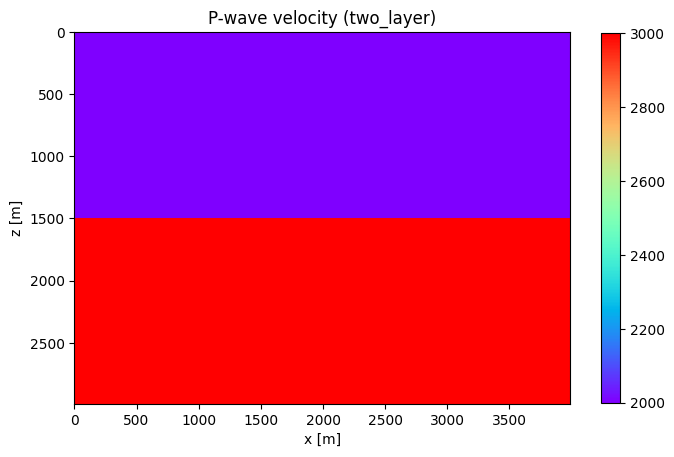

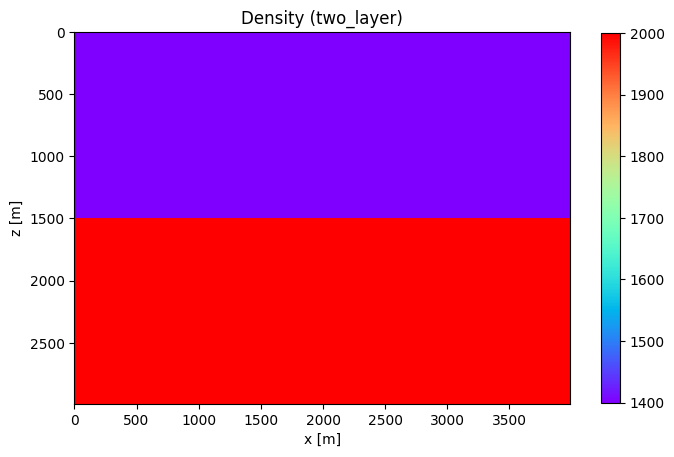

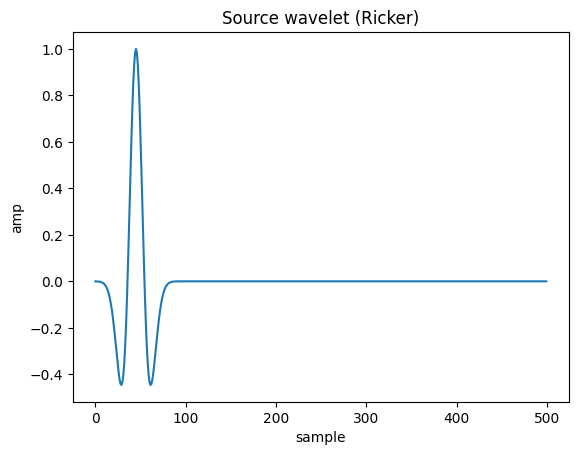

Starting FD module with dx=10.000000 dt=0.002000
Velocity model nx=400 z=300 cmin=2000.000000 cmax=3000.000000
Given cmin, maximum dx=13.333333
Given cmax, maximum dt=0.002357
Running simulation in Numpy



100%|██████████| 800/800 [00:13<00:00, 61.33it/s, t==1.598000 s, t_index=799]



Duration: 13.05 sec



<Figure size 640x480 with 0 Axes>

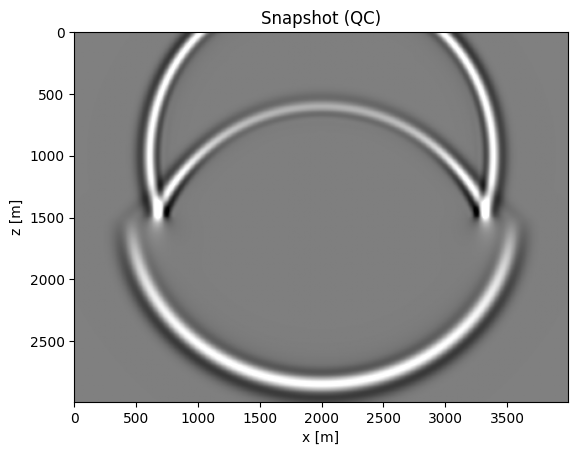

[GIF] Building frames from 800 timesteps with step=4 (≈200 frames, saving to /content/outputs/wave_snapshots.gif)
[OK] GIF written: /content/outputs/wave_snapshots.gif


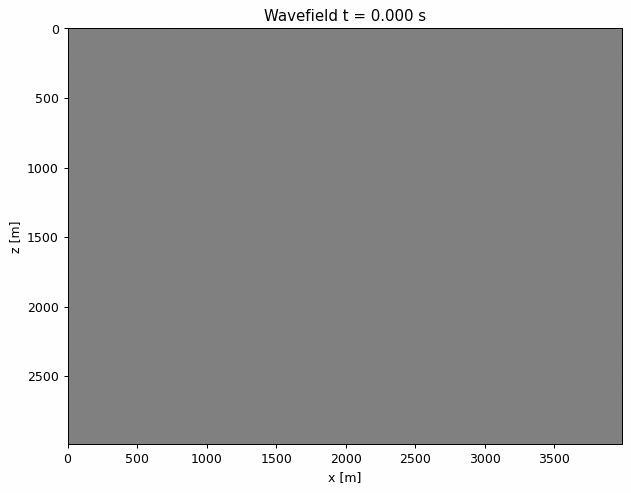

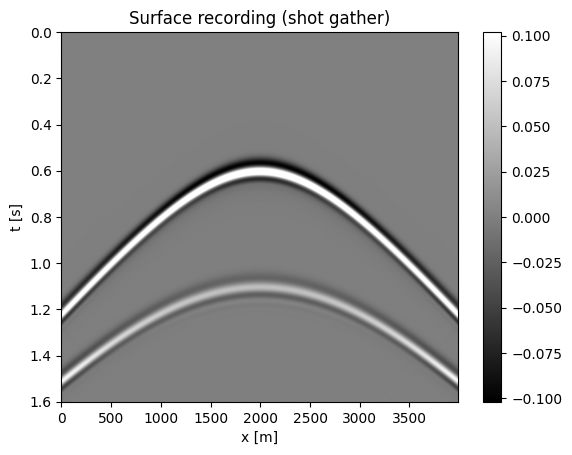

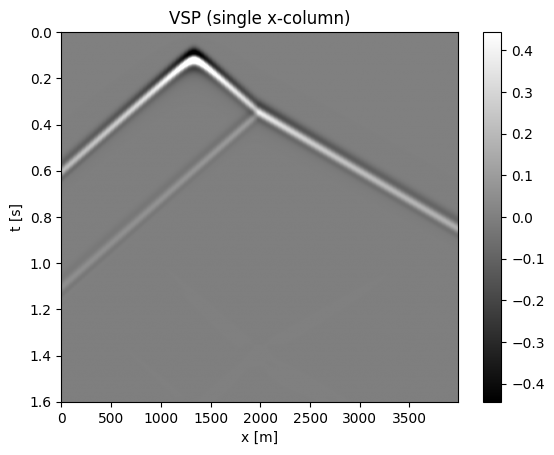

In [14]:
# ================== 1) Deps & imports ==================
!pip -q install numpy matplotlib scipy imageio

import os, sys, glob, importlib.util, traceback, io
from zipfile import ZipFile
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import imageio.v2 as imageio

# ================== 2) Config (defaults; you’ll be prompted for model type) ==================
# ZIP handling (only used if /content/src doesn't exist yet)
ZIP_NAME_HINT = "JMAG111_FD_and_ImagingDemonstration"   # prefer zips with this string
EXTRACT_PATH  = "/content"

# Two-layer params
layer_interface_depth_m = 1500.0     # interface depth (m)
cp_top,  rho_top  = 2000.0, 1400.0   # top layer velocity/density
cp_bot,  rho_bot  = 3000.0, 2000.0   # bottom layer velocity/density

# Inclusion params (circular)
inc_center_x_frac = 0.50   # fraction of model width (0..1)
inc_center_z_m    = 1000.0 # depth in meters
inc_radius_m      = 300.0  # radius in meters
cp_inc, rho_inc   = 1800.0, 1300.0

# Simulation grid / physics
free_surface = 0    # 0=no free surface; 1=pressure=0 at surface
nx, nz       = 400, 300
dx           = 10.0
dz           = dx
dt           = 0.0020
c0, rho0     = 2000.0, 1400.0

# Source
src_fmax       = 30
single_source  = 1            # 1=single monopole/dipole; 0=plane-wave array
src_type       = 'monopole'   # 'monopole' or 'dipole'
ntwav          = 500

# Modeling duration
ntmod            = 800
show_QC_interval = 0          # set >0 for live snapshots during run

# GIF controls
FRAME_STEP = 4     # take every Nth frame
FPS        = 12
DPI        = 90
CLIP       = 0.2   # fraction of max |amp| for contrast
CMAP       = 'gray'
OUT_DIR    = "/content/outputs"
GIF_NAME   = "wave_snapshots.gif"

# ================== 3) Helpers ==================
def find_src_dirs():
    return [p for p in (glob.glob("/content/src") + glob.glob("/content/**/src", recursive=True))
            if os.path.isdir(p)]

def ensure_path_first(path):
    path = os.path.abspath(path)
    if path in sys.path:
        sys.path.remove(path)
    sys.path.insert(0, path)

def print_tree(root, depth=2):
    root = os.path.abspath(root)
    print(f"[TREE] {root}")
    for dirpath, dirnames, filenames in os.walk(root):
        level = dirpath[len(root):].count(os.sep)
        if level > depth:
            continue
        indent = "  " * level
        print(f"{indent}{os.path.basename(dirpath) or dirpath}/")
        for f in filenames[:30]:
            print(f"{indent}  {f}")
        if len(filenames) > 30:
            print(f"{indent}  ... (+{len(filenames)-30} more files)")

def unzip_to_content(zip_path, extract_path="/content"):
    with ZipFile(zip_path, "r") as zf:
        zf.extractall(extract_path)
    print(f"[OK] Extracted: {os.path.basename(zip_path)} -> {extract_path}")

def pick_existing_zip():
    zips = [os.path.join("/content", z) for z in os.listdir("/content") if z.lower().endswith(".zip")]
    if not zips:
        return None
    hinted = [z for z in zips if ZIP_NAME_HINT.lower() in os.path.basename(z).lower()]
    return (hinted or sorted(zips, key=len))[0]

def import_by_filename(src_root, base_names):
    result = {}
    for base in base_names:
        target = base if base.endswith(".py") else f"{base}.py"
        matches = glob.glob(os.path.join(src_root, "**", target), recursive=True)
        if not matches:
            print(f"[WARN] No file named '{target}' found under {src_root}")
            result[base.replace(".py","")] = None
            continue
        matches.sort(key=lambda p: p.count(os.sep))  # prefer least nested
        pick = matches[0]
        modname = os.path.relpath(pick, src_root).replace(".py","").replace(os.sep,".")
        try:
            spec = importlib.util.spec_from_file_location(modname, pick)
            mod = importlib.util.module_from_spec(spec)
            sys.modules[modname] = mod
            spec.loader.exec_module(mod)  # type: ignore
            print(f"[OK] Imported '{modname}' from {pick}")
            result[base.replace(".py","")] = mod
        except Exception as e:
            import traceback as _tb
            print(f"[ERR] Failed importing '{modname}' from {pick}:\n{_tb.format_exc()}")
            result[base.replace(".py","")] = None
    return result

def prompt_model_switch():
    print("\n=== Choose medium type ===")
    print("  1) homogeneous")
    print("  2) two_layer")
    print("  3) inclusion")
    print("  4) two_layer_plus_inclusion")
    choice = input("Enter 1-4 (default=2): ").strip()
    mapping = {"1": "homogeneous", "2": "two_layer", "3": "inclusion", "4": "two_layer_plus_inclusion"}
    return mapping.get(choice, "two_layer")

# ================== 4) Idempotent src discovery (no re-upload unless needed) ==================
SRC = None
src_dirs = find_src_dirs()
if src_dirs:
    src_dirs.sort(key=len)
    SRC = src_dirs[0]
    print(f"[INFO] Found existing src: {SRC} (skipping upload & unzip)")
else:
    existing_zip = pick_existing_zip()
    if existing_zip:
        print(f"[INFO] Found zip in /content: {os.path.basename(existing_zip)} (skipping upload)")
        unzip_to_content(existing_zip, EXTRACT_PATH)
    else:
        print("[UPLOAD] No src or zip found. Please upload the .zip now.")
        from google.colab import files
        uploaded = files.upload()
        if not uploaded:
            raise RuntimeError("No files uploaded.")
        uploaded_names = list(uploaded.keys())
        uploaded_names.sort(key=lambda n: (ZIP_NAME_HINT.lower() not in n.lower(), len(n)))
        chosen = uploaded_names[0]
        zip_path = os.path.join("/content", chosen)
        unzip_to_content(zip_path, EXTRACT_PATH)

    src_dirs = find_src_dirs()
    if not src_dirs:
        print_tree("/content", depth=2)
        raise FileNotFoundError(
            "Unzipped, but no 'src' directory found under /content. "
            "Move/rename your code to a 'src' folder."
        )
    src_dirs.sort(key=len)
    SRC = src_dirs[0]

ensure_path_first(SRC)
print(f"[OK] Using src: {SRC}")
print_tree(SRC, depth=2)

# ================== 5) Import local libs ==================
mods = import_by_filename(SRC, base_names=["seistools.py", "fdtdac.py"])
seistools = mods.get("seistools")
fdtdac    = mods.get("fdtdac")

if seistools is None:
    try:
        import seistools  # type: ignore
        print("[OK] Imported 'seistools' via plain import")
    except Exception:
        pass
if fdtdac is None:
    try:
        import fdtdac  # type: ignore
        print("[OK] Imported 'fdtdac' via plain import")
    except Exception:
        pass

if seistools is None or fdtdac is None:
    raise ImportError("Could not import 'seistools' and/or 'fdtdac'. Check filenames under src.")

# ================== 6) Prompt model type & build model ==================
MODEL_SWITCH = prompt_model_switch()
print(f"[CHOICE] MODEL_SWITCH = {MODEL_SWITCH}")

# Base homogeneous
cp_grid  = np.full((nz, nx), c0,   dtype=float)
rho_grid = np.full((nz, nx), rho0, dtype=float)

xax = np.arange(nx) * dx
zax = np.arange(nz) * dz

if MODEL_SWITCH in ('two_layer', 'two_layer_plus_inclusion'):
    iz_int = int(round(layer_interface_depth_m / dz))
    iz_int = max(1, min(nz-1, iz_int))
    cp_grid[:iz_int, :]  = cp_top
    rho_grid[:iz_int, :] = rho_top
    cp_grid[iz_int:, :]  = cp_bot
    rho_grid[iz_int:, :] = rho_bot

if MODEL_SWITCH in ('inclusion', 'two_layer_plus_inclusion'):
    cx_m = xax[int(nx * np.clip(inc_center_x_frac, 0.0, 1.0))]
    cz_m = inc_center_z_m
    X, Z = np.meshgrid(xax, zax)
    mask = (X - cx_m)**2 + (Z - cz_m)**2 <= inc_radius_m**2
    cp_grid[mask]  = cp_inc
    rho_grid[mask] = rho_inc

if free_surface > 0:
    cp_grid[0, :] = 0.0

print("cp[min,max] =", float(cp_grid.min()), float(cp_grid.max()))
print("rho[min,max]=", float(rho_grid.min()), float(rho_grid.max()))

# QC plots (auto-contrast)
xplot = max(6, nx*0.02); zplot = max(4, nz*0.02)
plt.figure(figsize=(xplot,zplot))
plt.imshow(cp_grid, cmap="rainbow",
           extent=[xax.min(),xax.max(),zax.max(),zax.min()])
plt.colorbar(shrink=0.8); plt.xlabel('x [m]'); plt.ylabel('z [m]'); plt.title(f'P-wave velocity ({MODEL_SWITCH})'); plt.show()

plt.figure(figsize=(xplot,zplot))
plt.imshow(rho_grid, cmap="rainbow",
           extent=[xax.min(),xax.max(),zax.max(),zax.min()])
plt.colorbar(shrink=0.8); plt.xlabel('x [m]'); plt.ylabel('z [m]'); plt.title(f'Density ({MODEL_SWITCH})'); plt.show()

# ================== 7) Source & run ==================
f0 = src_fmax/2.5
t0 = 0.09*30/src_fmax

if single_source == 1:
    src_z_index = 100
    src_x_index = nx // 2
    if not hasattr(seistools, "gen_ricker"):
        raise AttributeError("seistools.gen_ricker not found in your src.")
    src_data = seistools.gen_ricker(ntwav, dt, f0, t0)
    plt.figure(); plt.plot(src_data); plt.title('Source wavelet (Ricker)'); plt.xlabel('sample'); plt.ylabel('amp'); plt.show()
else:
    src_z_index = 100
    src_x_index = np.arange(nx, dtype=int)
    src_data = np.zeros((nx, ntwav))
    inc_src = 50
    dt0     = 0.000
    src_t0  = t0 + src_x_index * dt0
    nxtap   = 50
    for k in range(len(src_x_index)):
        amp = (k/nxtap) if k < nxtap else ((nx-k)/nxtap if k > nx-nxtap else 1.0)
        if k % inc_src != 0: amp = 0.0
        src_data[k,:] = amp * seistools.gen_ricker(ntwav, dt, f0, src_t0[k])
    plt.figure(); plt.imshow(src_data.T, aspect='auto'); plt.title('Multi-source wavefield'); plt.xlabel('source index'); plt.ylabel('sample'); plt.show()

if free_surface > 0 and src_z_index == 0:
    src_z_index = 1

izrcv = 0
if free_surface > 0 and izrcv == 0:
    izrcv = 1

boundary_n_gridpoints      = 20
boundary_method_order      = 2
boundary_absorbing_function= 'cosine'

if not hasattr(fdtdac, "FDTDAC"):
    raise AttributeError("fdtdac.FDTDAC not found in your src.")
fdtd = fdtdac.FDTDAC(cp_grid, rho_grid, dx, dt, src_data, src_x_index, src_z_index, src_type, src_fmax,
                     boundary_method_order, boundary_n_gridpoints, boundary_absorbing_function)

shot = fdtd.run_simulation(ntmod, show_QC_interval)  # shape: (nt, nz, nx)

# One snapshot QC
itsnap = min(400, ntmod-1)
snap   = shot[itsnap,:,:]
vmax   = 0.5 * float(np.max(np.abs(snap)))
extent = [xax.min(), xax.max(), zax.max(), zax.min()]
plt.figure()
plt.imshow(snap, aspect=1.0, cmap='gray', vmin=-vmax, vmax=vmax, extent=extent)
plt.xlabel('x [m]'); plt.ylabel('z [m]'); plt.title('Snapshot (QC)'); plt.show()

# ================== 8) Build a looping GIF (backend-agnostic) ==================
os.makedirs(OUT_DIR, exist_ok=True)
GIF_PATH = os.path.join(OUT_DIR, GIF_NAME)

nt_, nz_, nx_ = shot.shape
extent = [xax.min(), xax.max(), zax.max(), zax.min()]
absmax = float(np.max(np.abs(shot)))
vmax   = max(1e-12, CLIP*absmax)

frames = []
print(f"[GIF] Building frames from {nt_} timesteps with step={FRAME_STEP} "
      f"(≈{(nt_-1)//FRAME_STEP+1} frames, saving to {GIF_PATH})")

for it in range(0, nt_, FRAME_STEP):
    fig = plt.figure(figsize=(nx_/50, nz_/50), dpi=DPI)
    plt.imshow(shot[it,:,:], aspect=1.0, cmap=CMAP, vmin=-vmax, vmax=vmax, extent=extent)
    plt.xlabel('x [m]'); plt.ylabel('z [m]')
    plt.title(f'Wavefield t = {it*dt:0.3f} s')

    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=DPI, bbox_inches='tight')
    buf.seek(0)
    frame = imageio.imread(buf)
    frames.append(frame)
    plt.close(fig)

imageio.mimsave(GIF_PATH, frames, fps=FPS, loop=0)
print(f"[OK] GIF written: {GIF_PATH}")

from IPython.display import Image, display
display(Image(filename=GIF_PATH))

# ================== 9) Shot gather & VSP (static) ==================
shot_meas = shot[:, izrcv, :]
vmax = 0.5 * float(np.max(np.abs(shot_meas)))
extent = [xax.min(), xax.max(), ntmod*dt, 0.0]
plt.figure()
plt.imshow(shot_meas, aspect='auto', cmap="gray", vmin=-vmax, vmax=vmax, extent=extent)
plt.xlabel('x [m]'); plt.ylabel('t [s]')
plt.colorbar(); plt.title('Surface recording (shot gather)'); plt.show()

ixvsp   = nx//2 + 5
vsp_meas= shot[:, :, ixvsp]
vmax    = 0.5 * float(np.max(np.abs(vsp_meas)))
extent  = [xax.min(), xax.max(), ntmod*dt, 0.0]
plt.figure()
plt.imshow(vsp_meas, aspect='auto', cmap="gray", vmin=-vmax, vmax=vmax, extent=extent)
plt.xlabel('x [m]'); plt.ylabel('t [s]')
plt.colorbar(); plt.title('VSP (single x-column)'); plt.show()
